**Short illustration on sparse coding**

# Introduction

In this notebook, we illustrate the notion of sparse coding. In the following the dictionary will be fixed.

## Setup

**Import**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.linalg import circulant
from scipy.signal import argrelmax, morlet2, ricker, sawtooth
from sklearn.decomposition import SparseCoder

**Utility functions**

In [ ]:
def pad_with_zeros(signal: np.ndarray, desired_length: int) -> np.ndarray:
    """Add zeros at the start and end of a signal until it reached the desired lenght.

    The same number of zeros is added on each side, except when desired_length-signal.shape[0] is odd,
    in which case, there is one more zero at the beginning.
    """
    if signal.ndim == 1:
        (n_samples,) = signal.shape
        n_dims = 1
    else:
        n_samples, n_dims = signal.shape

    assert desired_length >= n_samples

    length_diff = desired_length - n_samples
    pad_width_at_the_start = pad_width_at_the_end = length_diff // 2
    pad_width_at_the_start += (
        length_diff - pad_width_at_the_end - pad_width_at_the_start
    )

    return np.pad(
        signal.reshape(n_samples, n_dims).astype(float),
        pad_width=((pad_width_at_the_start, pad_width_at_the_end), (0, 0)),
        mode="constant",
        constant_values=(0,),
    )

In [ ]:
def pad_at_the_end(signal: np.ndarray, desired_length: int) -> np.ndarray:
    """Add zeros at the end of a signal until it reached the desired length."""
    if signal.ndim == 1:
        (n_samples,) = signal.shape
        n_dims = 1
    else:
        n_samples, n_dims = signal.shape

    assert desired_length >= n_samples

    pad_width_at_the_end = desired_length - n_samples

    return np.pad(
        signal.reshape(n_samples, n_dims).astype(float),
        pad_width=((0, pad_width_at_the_end), (0, 0)),
        mode="constant",
        constant_values=(0,),
    )

In [ ]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [ ]:
def get_sparse_codes(
    signal: np.ndarray, dictionary: np.ndarray, penalty: float
):
    coder = SparseCoder(
        dictionary=dictionary,
        transform_algorithm="lasso_lars",
        transform_alpha=penalty,
        positive_code=True,
    )
    return coder.transform(signal.reshape(1, -1))

In [ ]:
def get_dictionary_from_single_atom(atom, n_samples):
    atom_width = atom.shape[0]
    dictionary = circulant(pad_at_the_end(atom, n_samples).flatten())[
        :, : n_samples - atom_width + 1
    ].T
    return dictionary

In [ ]:
def plot_CDL(signal, codes, atoms, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (n_atoms, atom_length) = atoms.shape
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(atoms[i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(codes[i])
        plt.ylim((np.min(codes), np.max(codes)))

## Simulate patterns

In [ ]:
atom_width = 100  # pattern length

atom_1 = np.ones(atom_width)
atom_1[:33] = 0
atom_1[-33:] = 0

fig, ax = fig_ax((5, 3))

tt = np.arange(atom_width)

ax.plot(tt, atom_1, "k", lw=1)
_ = ax.set_xlim(0, atom_width)

In [ ]:
t = np.linspace(0, 1, atom_width)
atom_2 = sawtooth(2 * np.pi * 3 * t) + 1
atom_2[:33] = 0
atom_2[-33:] = 0

fig, ax = fig_ax((5, 3))
ax.plot(tt, atom_2, "k", lw=1)
_ = ax.set_xlim(0, atom_width)

## Simulate activations

In [ ]:
n_samples = 1000

activations_1 = np.random.binomial(n=1, p=0.005, size=n_samples)
activations_2 = np.random.binomial(n=1, p=0.001, size=n_samples)

fig, ax = fig_ax()
_ = ax.plot(activations_1, label="activations 1")
_ = ax.plot(activations_2, label="activations 2")

plt.legend()

signal = np.convolve(activations_1, atom_1, mode="same")
signal += np.convolve(activations_2, atom_2, mode="same")

fig, ax = fig_ax()
_ = ax.plot(signal)

## Sparse coding

Reformulation as a regular sparse coding task (not convolutional).

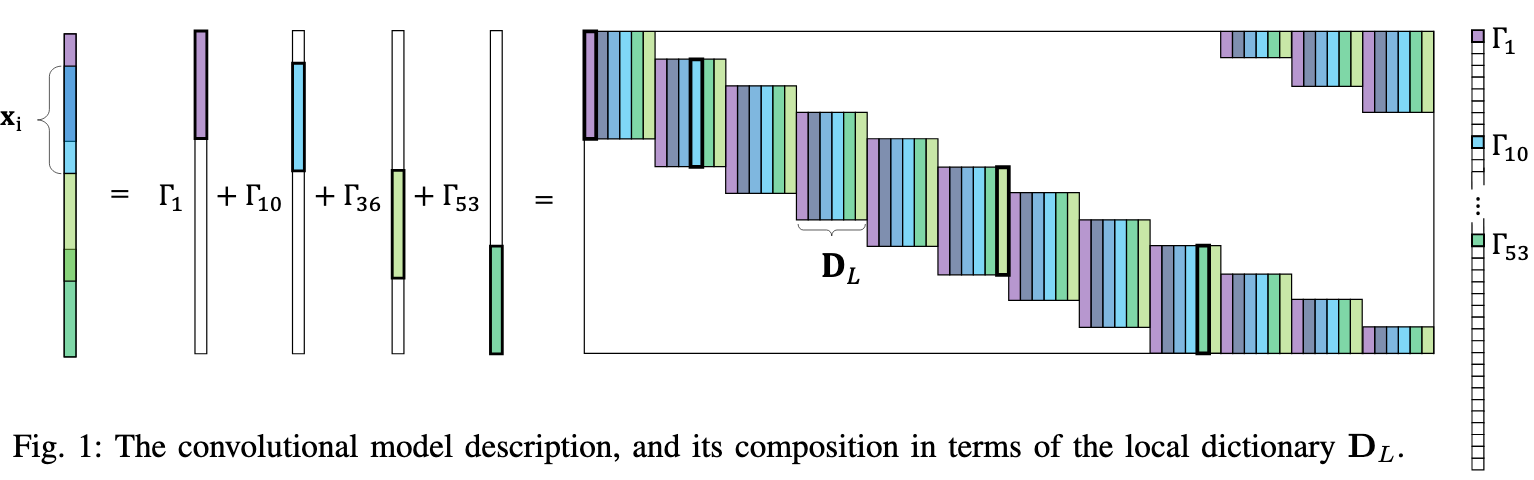

(Taken from _Papyan, V., Sulam, J., & Elad, M. (2017). Working locally thinking globally: Theoretical guarantees for convolutional sparse coding. IEEE Transactions on Signal Processing, 65(21), 5687-5701_)

In [ ]:
dictionary_width = n_samples - atom_width + 1

In [ ]:
dictionary_1 = get_dictionary_from_single_atom(
    atom=atom_1, n_samples=n_samples
)
dictionary_2 = get_dictionary_from_single_atom(
    atom=atom_2, n_samples=n_samples
)

# Reformulation as a regular sparse coding task (not convolutional).

dictionary = np.r_[dictionary_1, dictionary_2]  # concatenation

# actual sparse coding
sparse_codes = get_sparse_codes(
    signal=signal, dictionary=dictionary, penalty=50
)

# reconstructed signal
reconstruction = sparse_codes.dot(dictionary).flatten()

Look at the reconstruction.

In [ ]:
fig, ax = fig_ax()

ax.plot(signal, label="Original")
ax.plot(reconstruction, label="Reconstruction")
ax.set_title(f"MSE: {((signal-reconstruction)**2).mean():.3f}")
_ = plt.legend()

Look at activations.

In [ ]:
sparse_codes_1 = sparse_codes[:, :dictionary_width].flatten()
sparse_codes_2 = sparse_codes[:, dictionary_width:].flatten()

plot_CDL(
    signal,
    codes=np.c_[sparse_codes_1, sparse_codes_2].T,
    atoms=np.c_[atom_1, atom_2].T,
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you observe?</p>
</div>